# CNN Classification task using PyTorch on MNIST dataset

## `1.` Import needed libraries

In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from torchsummary import summary

## `2.` Load the data


In [ ]:
data_transform = transforms.Compose([
            transforms.Resize((32,32)) ,
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,))])

In [ ]:
train_set = datasets.MNIST(root = './data' , train = True , download= True , transform= data_transform)
train_loader =DataLoader(train_set , batch_size= 64 , shuffle= True , drop_last=True)

In [ ]:
test_set = datasets.MNIST(root = './data' , train = False , download= True , transform= data_transform)
test_loader =DataLoader(test_set , batch_size= 64 , shuffle= False , drop_last=True)

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Input shape: {data.shape}, Target shape: {target.shape}")
    break

Input shape: torch.Size([64, 1, 32, 32]), Target shape: torch.Size([64])


### plot samples of data

In [ ]:
def plot_samples(samples):
  '''
  This function plots the first 9 samples form the passed dataset
  ----------------------------------
  parameters:
  samples : the dataset you want to plot samples from it

  '''
  plt.figure(figsize=(12,8))
  for i in range(9):
    plt.subplot(3, 3 , i+1)
    plt.imshow(samples[i].permute(1,2,0) , cmap = 'gray')
    plt.axis('off')

  plt.tight_layout()
  plt.show();

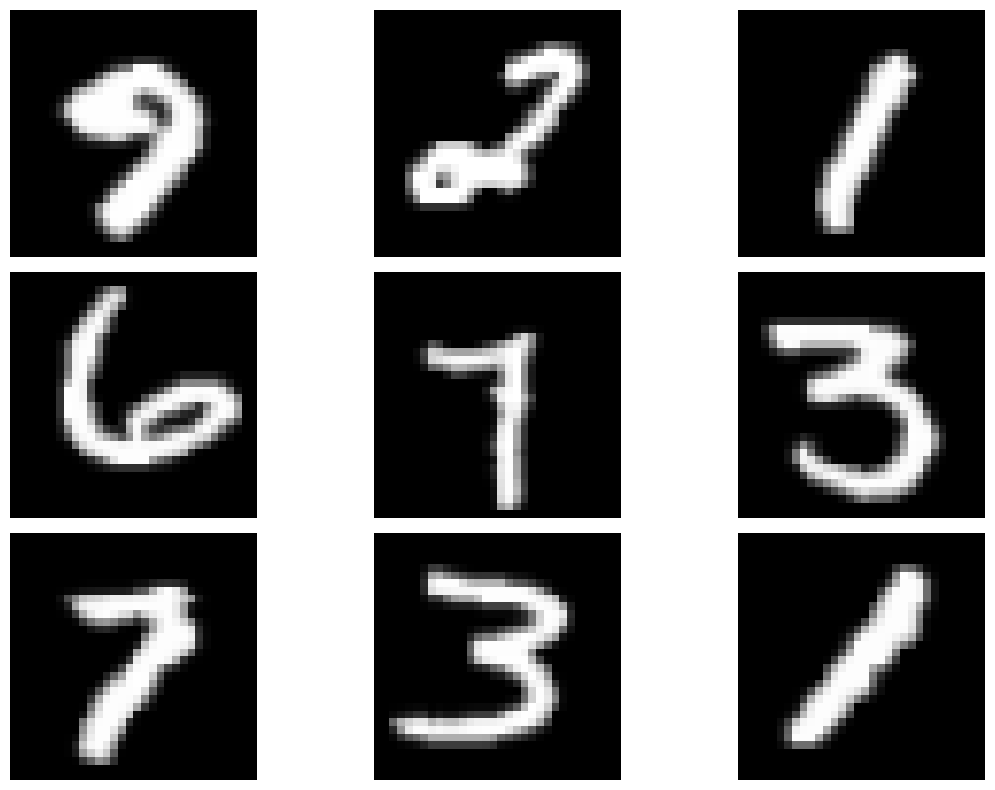

In [ ]:
for batch in train_loader:
  images , labels = batch
  plot_samples(images)
  break

## `3.` Model building

### `Custom CNN architecture`

In [ ]:
class Custom_CNN(nn.Module):
    def __init__(self, activation='relu', pooling='max', dropout_prob=0.0):
        super(Custom_CNN, self).__init__()
        self.activation_fn = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU()
        }
        self.pooling_fn = {
            'max': nn.MaxPool2d(kernel_size=2, stride=2),
            'avg': nn.AvgPool2d(kernel_size=2, stride=2)
        }

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = activation
        self.pooling = pooling

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.pool = self.pooling_fn[self.pooling]

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn[self.activation](x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation_fn[self.activation](x)
        x = self.pool(x)
        x = x.view(-1, 32 * 8* 8)
        x = self.fc1(x)
        x = self.activation_fn[self.activation](x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### `LeNet5 architecture `

In [ ]:
class LeNet5(nn.Module):
    def __init__(self , activation = 'relu' , pooling = 'max' , dropout_prob = 0.0):
        super(LeNet5, self).__init__()
        self.activation_fn = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU()
            }
        self.pooling_fn = {
                'max': nn.MaxPool2d(kernel_size=2, stride=2),
                'avg': nn.AvgPool2d(kernel_size=2, stride=2)
            }

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = activation
        self.pooling = pooling

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        # Average Pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pooling_fn[self.pooling](self.activation_fn[self.activation](self.conv1(x)))
        x = self.pooling_fn[self.pooling](self.activation_fn[self.activation](self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(self.activation_fn[self.activation](self.fc1(x)))
        x = self.dropout(self.activation_fn[self.activation](self.fc2(x)))
        x = self.fc3(x)
        return x

## `4.` Model training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
cnn_model = Custom_CNN().to(device)
summary(cnn_model ,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 268,362
Trainable params: 268,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.02
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


In [ ]:
lenet_model = LeNet5().to(device)
summary(lenet_model , input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [ ]:
num_epochs = 50
criterion = nn.CrossEntropyLoss()

In [81]:
def model_train(model, device, train_loader,test_loader, optimizer, criterion, epochs):
    model.train()

    train_losses = []
    test_accuracies = []
    test_loss = 0
    test_losses = []

    optimizers = {
        'adam': torch.optim.Adam(model.parameters()),
        'SGD' : torch.optim.SGD(model.parameters()),
        'RMSProp' : torch.optim.RMSprop(model.parameters())}

    for epoch in range(epochs):
        train_loss = 0
        num_batches = len(train_loader)
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizers[optimizer].zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizers[optimizer].step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {loss.item()}")
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        test_loss , accuracy = evaluate_model(model, device, test_loader)
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

    visualize_results(train_losses , test_accuracies , epochs)
    return train_losses, test_losses , test_accuracies

## `5.` Model evaluation

In [ ]:
def evaluate_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

## `6.` Visualizing results

In [ ]:
def visualize_results(losses, accuracies, epochs):
    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy')

    plt.tight_layout()
    plt.show()


# `i` Model process

In [ ]:
torch.manual_seed(42)

## CNN trainnig:

In [77]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = cnn_model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break


Output shape: torch.Size([64, 10])
Target shape: torch.Size([64])


In [ ]:
cnn_losses, cnn_test_losses, cnn_accuracies = model_train(cnn_model, device, train_loader, test_loader, 'adam', criterion, num_epochs)

Epoch 1, Batch 100, Loss: 9.240001236321405e-05
Epoch 1, Batch 200, Loss: 0.00044742642785422504
Epoch 1, Batch 300, Loss: 0.0002441771503072232
Epoch 1, Batch 400, Loss: 1.1627032108663116e-05
Epoch 1, Batch 500, Loss: 0.0018112771213054657
Epoch 1, Batch 600, Loss: 0.00010780690354295075
Epoch 1, Batch 700, Loss: 8.289769175462425e-05
Epoch 1, Batch 800, Loss: 0.0031984851229935884
Epoch 1, Batch 900, Loss: 0.006324777379631996
Epoch 1, Loss: 0.0004, Accuracy: 99.02%
Epoch 2, Batch 100, Loss: 0.0005330916028469801
Epoch 2, Batch 200, Loss: 0.0009299826342612505
Epoch 2, Batch 300, Loss: 2.685379695321899e-05
Epoch 2, Batch 400, Loss: 0.0020515902433544397
Epoch 2, Batch 500, Loss: 0.00013571709860116243
Epoch 2, Batch 600, Loss: 0.00010230914631392807
Epoch 2, Batch 700, Loss: 2.9959144740132615e-05
Epoch 2, Batch 800, Loss: 0.014194798655807972
Epoch 2, Batch 900, Loss: 0.0002989408385474235
Epoch 2, Loss: 0.0000, Accuracy: 99.13%
Epoch 3, Batch 100, Loss: 0.00040637562051415443
Epo

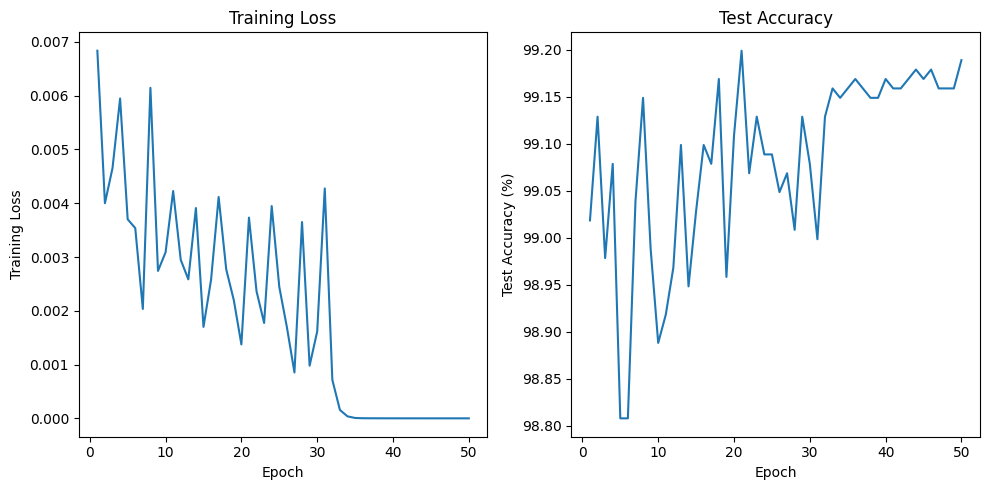

In [84]:
visualize_results(cnn_losses ,cnn_accuracies ,num_epochs )

## LeNet trainnig:

In [85]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = lenet_model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break


Output shape: torch.Size([64, 10])
Target shape: torch.Size([64])


Epoch 1, Batch 100, Loss: 0.17177128791809082
Epoch 1, Batch 200, Loss: 0.1734156310558319
Epoch 1, Batch 300, Loss: 0.08873432874679565
Epoch 1, Batch 400, Loss: 0.1363636702299118
Epoch 1, Batch 500, Loss: 0.03519752621650696
Epoch 1, Batch 600, Loss: 0.030760128051042557
Epoch 1, Batch 700, Loss: 0.07117905467748642
Epoch 1, Batch 800, Loss: 0.06933112442493439
Epoch 1, Batch 900, Loss: 0.07558131217956543
Epoch 1, Loss: 0.0039, Accuracy: 97.86%
Epoch 2, Batch 100, Loss: 0.04202621430158615
Epoch 2, Batch 200, Loss: 0.06526244431734085
Epoch 2, Batch 300, Loss: 0.0973351001739502
Epoch 2, Batch 400, Loss: 0.0564236082136631
Epoch 2, Batch 500, Loss: 0.09547246247529984
Epoch 2, Batch 600, Loss: 0.008254158310592175
Epoch 2, Batch 700, Loss: 0.035431984812021255
Epoch 2, Batch 800, Loss: 0.010810229927301407
Epoch 2, Batch 900, Loss: 0.11029299348592758
Epoch 2, Loss: 0.0061, Accuracy: 98.53%
Epoch 3, Batch 100, Loss: 0.05447333678603172
Epoch 3, Batch 200, Loss: 0.02672349475324154


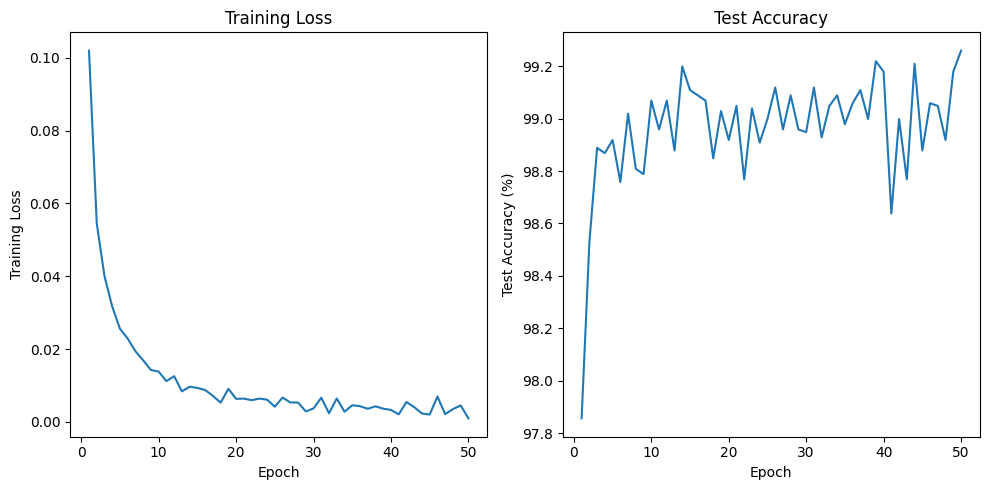

In [86]:
lenet_losses, lenet_test_losses, lenet_accuracies = model_train(lenet_model, device, train_loader, test_loader, 'adam', criterion, num_epochs)

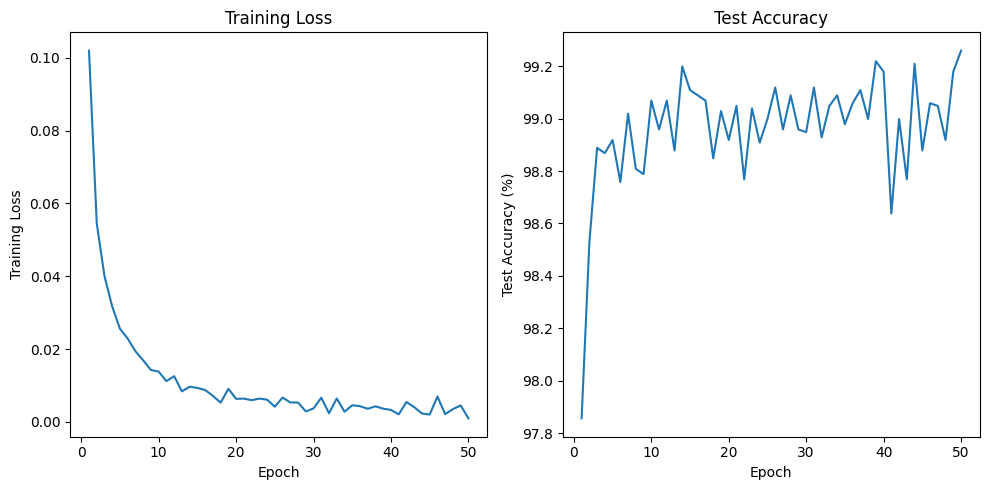

In [87]:
visualize_results(lenet_losses ,lenet_accuracies ,num_epochs )

## Trying different approaches:

In [88]:
cnn_model= Custom_CNN(activation = 'sigmoid' , pooling = 'avg' , dropout_prob = 0.2 ).to(device)
summary(cnn_model , (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         AvgPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         AvgPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 268,362
Trainable params: 268,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.02
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


Epoch 1, Batch 100, Loss: 2.2809455394744873
Epoch 1, Batch 200, Loss: 1.0115125179290771
Epoch 1, Batch 300, Loss: 0.6024576425552368
Epoch 1, Batch 400, Loss: 0.4173981249332428
Epoch 1, Batch 500, Loss: 0.423704594373703
Epoch 1, Batch 600, Loss: 0.32715895771980286
Epoch 1, Batch 700, Loss: 0.5156826972961426
Epoch 1, Batch 800, Loss: 0.26016032695770264
Epoch 1, Batch 900, Loss: 0.39963898062705994
Epoch 1, Loss: 0.2326, Accuracy: 92.58%
Epoch 2, Batch 100, Loss: 0.3015833795070648
Epoch 2, Batch 200, Loss: 0.25110098719596863
Epoch 2, Batch 300, Loss: 0.2823132872581482
Epoch 2, Batch 400, Loss: 0.2267404943704605
Epoch 2, Batch 500, Loss: 0.2145155519247055
Epoch 2, Batch 600, Loss: 0.1245761513710022
Epoch 2, Batch 700, Loss: 0.12730860710144043
Epoch 2, Batch 800, Loss: 0.14553608000278473
Epoch 2, Batch 900, Loss: 0.2564297616481781
Epoch 2, Loss: 0.0961, Accuracy: 94.90%
Epoch 3, Batch 100, Loss: 0.1889050155878067
Epoch 3, Batch 200, Loss: 0.09402507543563843
Epoch 3, Batch

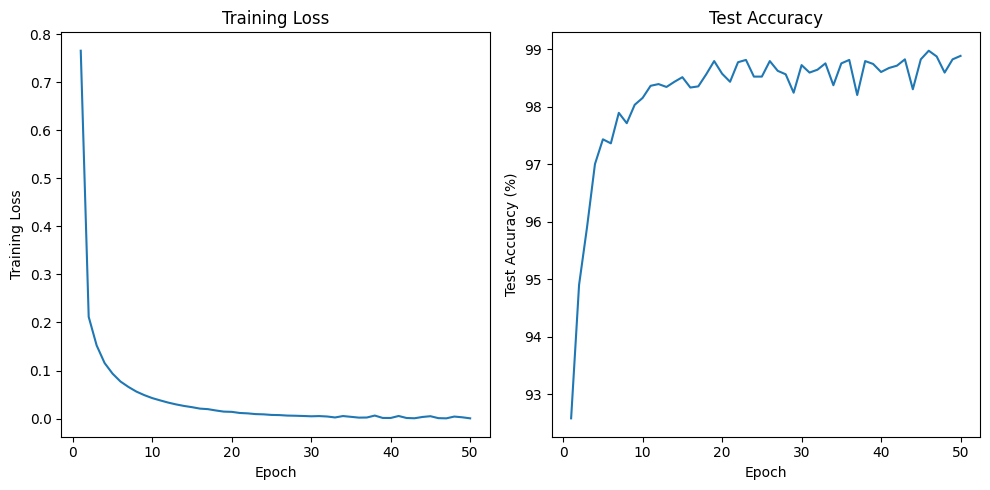

In [89]:
cnn_losses, cnn_test_losses, cnn_accuracies = model_train(cnn_model, device, train_loader, test_loader, 'adam', criterion, num_epochs)

In [91]:
lenet_model = LeNet5(activation = 'sigmoid' , pooling = 'avg' , dropout_prob = 0.2 ).to(device)
summary(lenet_model , (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


Epoch 1, Batch 100, Loss: 2.303236722946167
Epoch 1, Batch 200, Loss: 2.0005781650543213
Epoch 1, Batch 300, Loss: 1.0324666500091553
Epoch 1, Batch 400, Loss: 0.600247859954834
Epoch 1, Batch 500, Loss: 0.40645402669906616
Epoch 1, Batch 600, Loss: 0.5458115935325623
Epoch 1, Batch 700, Loss: 0.46076932549476624
Epoch 1, Batch 800, Loss: 0.2381652593612671
Epoch 1, Batch 900, Loss: 0.3545215427875519
Epoch 1, Loss: 0.4482, Accuracy: 92.67%
Epoch 2, Batch 100, Loss: 0.3499188721179962
Epoch 2, Batch 200, Loss: 0.09048072248697281
Epoch 2, Batch 300, Loss: 0.26976025104522705
Epoch 2, Batch 400, Loss: 0.11627141386270523
Epoch 2, Batch 500, Loss: 0.2013166844844818
Epoch 2, Batch 600, Loss: 0.04374288022518158
Epoch 2, Batch 700, Loss: 0.4374336302280426
Epoch 2, Batch 800, Loss: 0.17101530730724335
Epoch 2, Batch 900, Loss: 0.274239718914032
Epoch 2, Loss: 0.1722, Accuracy: 95.63%
Epoch 3, Batch 100, Loss: 0.12349488586187363
Epoch 3, Batch 200, Loss: 0.2182188630104065
Epoch 3, Batch 

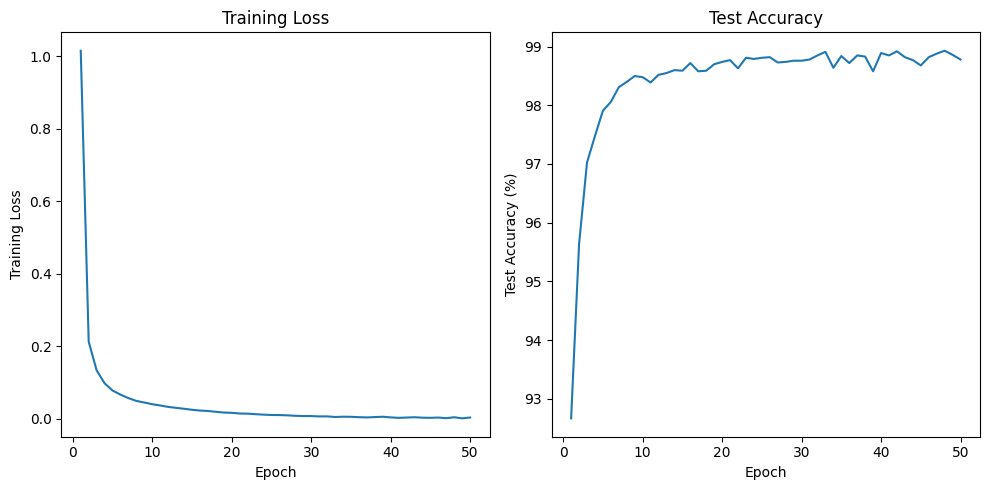

In [92]:
lenet_losses, lenet_test_losses, lenet_accuracies = model_train(lenet_model, device, train_loader, test_loader, 'adam', criterion, num_epochs)